In [1]:
from typing import TypedDict

from browser import ChromeBrowser
from browser.search.web import BraveBrowser
from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

MAX_STEPS = 5
BRAVE_SEARCH = BraveBrowser(browser=ChromeBrowser(), session_id="deep_web_search")

sh: pidof: command not found


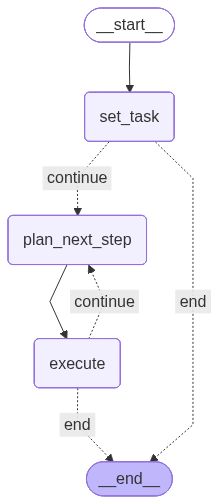

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, \
    AgentCapabilityCodeWriterExecutor, AgentCapabilityAudioProcessor, AgentCapabilityOutput
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[ContentResource] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    state["step"] = 0
    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(
        state["task"].objective,
        state["context"]
    )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] > MAX_STEPS:
        return "end"

    return "continue"

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=state["task"],
        context=state["context"]
    )

    state["capability_plan"] = CapabilityPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    activity, capability = state["capability_plan"].subplan[0]
    output = AgentCapabilityOutput(activity)
    capability_agent = capability(activity)

    if capability is AgentCapabilityDeepWebSearch:
        # Reinitiate the agent since it might need browser
        capability_agent = capability(activity=activity, search_browser=BRAVE_SEARCH)
        output = capability_agent.run()
    elif capability is AgentCapabilityUnstructuredDataProcessor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityCodeWriterExecutor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCapabilityAudioProcessor:
        output = capability_agent.run(state["resources"])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    if output.answers:
        state["answers"].extend(output.answers)
    if output.resources:
        state["resources"].extend(output.resources)

    # Update context with step results
    state["context"] += f"\nStep {state['step']}: {state['answers']}"
    state["step"] += 1

    return state


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)

workflow.add_edge(START, "set_task")
workflow.add_conditional_edges(
    "set_task",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)
workflow.add_edge("plan_next_step", "execute")
workflow.add_conditional_edges(
    "execute",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
from generalist.models.core import MLFlowLLMWrapper
from generalist.tools import planning, web_search, text_processing, code

# MONKEY PATCH THE LLM CALLS TO HAVE THE LOGGING IN STDOUT
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

In [ ]:
# Try evaluation with GAIA
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset

load_dotenv()


logging.getLogger().setLevel(logging.INFO)

gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be"
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632"
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
evaluation_tasks = [
    just_running_python_task_id,
    calc_sales_xlsx_task_id,
    sosa_many_studio_albums_task_id,
    running_to_the_moon_task_id,
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys]

    mlflow.langchain.autolog()  # this is needed to register traces within the experiment
    # mlflow.set_tracking_uri('http://localhost:5000')
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    print(experiment_url)

    question = sample["Question"]
    if sample["file_path"]:
        file_path = os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"])
        # FIXME: better do it with ContentResource
        question += f"\n Resource filepath: {file_path}"
    initial_state = init_state(question)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).


task_id = f918266a-b3e0-4914-865d-4faa564f1aef
Question = What is the final numeric output from the attached Python code?
Level = 1
Final answer = 0
file_name = f918266a-b3e0-4914-865d-4faa564f1aef.py
file_path = 2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py
Annotator Metadata = {'Steps': '1. Run the attached Python code', 'Number of steps': '1', 'How long did this take?': '30 seconds', 'Tools': '1. Python', 'Number of tools': '1'}
<Experiment: artifact_location='file:///Users/maksim.rostov/pdev/freelectron/free-generalist/notebooks/mlruns/131209864077811207', creation_time=1768504635443, experiment_id='131209864077811207', last_update_time=1768504635443, lifecycle_stage='active', name='gaia_f918266a_b3e0_4914_865d_4faa564f1aef', tags={'mlflow.experimentKind': 'custom_model_development'}>
